# Text Classification on Noisy IMDB Dataset using AutoKeras

## 1. Experiment Details
|Specification|Value|
|----|----|
|AutoML Algorithm|AutoKeras|
|Task|Text Classification|
|Dataset|IMDB Moview Review|
|Dataset Clean|No|
|Noise Type|Random|

## 2. Load Packages

In [1]:
# Packages for data processing
import numpy as np
import pandas as pd
from scripts.add_noise import add_gaussian_noise, add_random_noise
from scripts.data_preprocess import preprocess_text
from sklearn.model_selection import train_test_split

# Packages for AutoML framework execution
import autokeras as ak

# Packages for evaluation plots
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from scripts.plot_model_scores import get_plot_model

random_state = 42

Using TensorFlow backend


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yogesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/yogesh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 3. Load and Pre-process Dataset

In [2]:
# Gaussian noisy data is already computed and stored as dataset. However, the below code snippet can be used to generate new noisy data.
# """
df = pd.read_csv("../datasets/clean/imdb.csv")
noisy_df = df.copy()
noisy_df['review'] = noisy_df['review'].apply(lambda x: add_gaussian_noise(x, mean=0, std_dev=0.6))
noisy_df.to_csv("../datasets/noisy/imdb_noisy_gaussian.csv")
# """

# Get the required dataset from the datasets folder
imdb_df = pd.read_csv("../datasets/noisy/imdb_noisy_gaussian.csv", index_col=0)

In [3]:
# Random noisy data is already computed and stored as dataset. However, the below code snippet can be used to generate new noisy data.
# """
df = pd.read_csv("../datasets/clean/imdb.csv")
noisy_df = df.copy()
noisy_df['review'] = noisy_df['review'].apply(lambda x: add_random_noise(x, noise_level=0.1))
noisy_df.to_csv("../datasets/noisy/imdb_noisy_random.csv")
# """

# Get the required dataset from the datasets folder
imdb_df = pd.read_csv("../datasets/noisy/imdb_noisy_random.csv", index_col=0)

In [4]:
# Sample the data for experimentation purposes
# Some AutoML frameworks can take long time to test multiple pipelines on large-scale data (e.g. 4+ hours on 50K+ text data)
imdb_df = imdb_df.sample(frac=0.2, replace=False, random_state=random_state)

In [5]:
# Certain AutoML frameworks such as TPOT require the target variable to be explicitly named as 'target'
imdb_df.reset_index(inplace=True)
imdb_df.rename(columns={'sentiment':'target'}, inplace=True)
imdb_df['target'] = imdb_df['target'].apply(lambda x: 1 if x =='positive' else 0)

AutoKeras does not require explicit text pre-processing

In [6]:
imdb_df.head()

,index,review,target
0,33553,Iireally liked thUs Summersyam due to the lXok...,1
1,9427,Rot Nany televiQion showsuapqealXto vuite as m...,1
2,199,The fiUc quickly jetr to a major phase stenePw...,0
3,12447,JanD Austen VouldvKefieitely approve of this o...,1
4,39489,RxMeVtatlonsMwkre somewhat hdgh fFr me whKn I ...,0


## 4. Find Best Model using AutoML

In [7]:
# Split the dataset into traning and testing splits
X_train, X_test, y_train, y_test = train_test_split(imdb_df.loc[:, imdb_df.columns != 'target'], 
                                                    imdb_df.loc[:, 'target'], 
                                                    train_size=0.75, test_size=0.25, random_state=random_state)

In [8]:
# AutoKeras framework requires input to be a numpy array
X_train = np.array(X_train.loc[:, 'review'])
X_test = np.array(X_test.loc[:, 'review'])
y_train = np.array(y_train)
y_test = np.array(y_test)

In [9]:
# Initialize the built-in text classifier.
clf = ak.TextClassifier(overwrite=True, max_trials=3)

## 5. Train Model and Predict

In [10]:
# Feed the text classifier with training data.
clf.fit(X_train, y_train, epochs=2)

Trial 3 Complete [00h 00m 00s]

Best val_loss So Far: 0.5104007720947266
Total elapsed time: 00h 00m 22s


Epoch 1/2
235/235 [==============================] - 9s 37ms/step - loss: 0.6723 - accuracy: 0.5560
Epoch 2/2
235/235 [==============================] - 9s 37ms/step - loss: 0.5084 - accuracy: 0.7548
INFO:tensorflow:Assets written to: ./text_classifier/best_model/assets


INFO:tensorflow:Assets written to: ./text_classifier/best_model/assets


In [11]:
# Predict with the best model.
y_pred_automl = clf.predict(X_test)

79/79 [==============================] - 1s 11ms/step


## 6. Evaluate Model

In [16]:
# We now evaluate our model performances on this dataset and compare against the Naive Bayes benchmark
precision_automl = precision_score(y_true=y_test, y_pred=y_pred_automl)
recall_automl = recall_score(y_true=y_test, y_pred=y_pred_automl)
f1_automl = f1_score(y_true=y_test, y_pred=y_pred_automl)

model_names = ['AutoML-AutoKeras']
plot_title = 'Noisy Data - AutoKeras Performance'
f1_scores = [f1_automl]
recall_scores = [recall_automl]
precision_scores = [precision_automl]

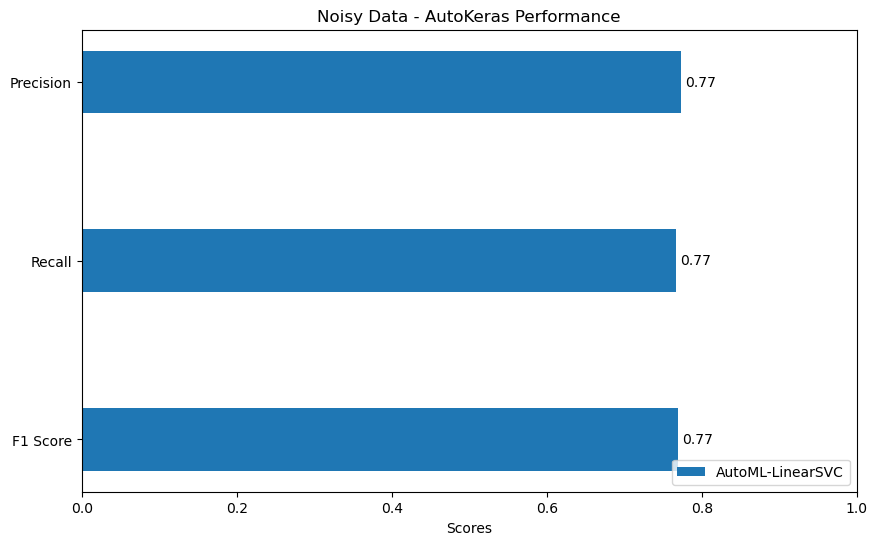

In [17]:
fig = get_plot_model(model_names=model_names, f1_scores=f1_scores, recall_scores=recall_scores, precision_scores=precision_scores, title=plot_title)
plt.show()